We can actually use our interval estimates to approximate all manner of Hardware properties such as:

* On CPU time of operations (e.g. some reads are slower than others)
* Request size distributions (e.g. some reads are bigger than others)
* Disk latency (e.g. some disks are faster or more consistent than others)

For a concrete example let's model a m5d drive which we [model](https://github.com/Netflix-Skunkworks/service-capacity-modeling/blob/dd1fb503b4505327d1cf14d2d614c0e796bb8f05/service_capacity_modeling/hardware/profiles/shapes/aws.json#L98) with an io latency distribution. Data for comparision comes from using `biosnoop` and [`histogram.py`](https://github.com/bitly/data_hacks/blob/master/data_hacks/histogram.py) on a Cassandra server (the threads that are servicing reads are from the SharedPool).

```bash
$ sudo /usr/share/bcc/tools/biosnoop > ios
$ grep SharedPool ios | tr -s ' ' | cut -f 8  -d ' ' > io_lat
$ cat io_lat | histogram.py -l -p
# NumSamples = 107517; Min = 0.06; Max = 2.43
# Mean = 0.118898; Variance = 0.002304; SD = 0.048005; Median 0.100000
# each ∎ represents a count of 569
    0.0600 -     0.0623 [    94]:  (0.09%)
    0.0623 -     0.0670 [     0]:  (0.00%)
    0.0670 -     0.0762 [   505]:  (0.47%)
    0.0762 -     0.0948 [ 33459]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (31.12%)
    0.0948 -     0.1318 [ 42706]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (39.72%)
    0.1318 -     0.2060 [ 29154]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (27.12%)
    0.2060 -     0.3542 [   994]: ∎ (0.92%)
    0.3542 -     0.6508 [   523]:  (0.49%)
    0.6508 -     1.2438 [    77]:  (0.07%)
    1.2438 -     2.4300 [     5]:  (0.00%)
```

In [1]:
from service_capacity_modeling.stats import gamma_for_interval
from service_capacity_modeling.interface import FixedInterval, Interval

import matplotlib.pyplot as plt
import numpy as np

In [2]:
real_data = np.loadtxt("m5d_cass_io_lat")
real_interval = np.percentile(real_data, [5, 50, 95])
print(f"{real_interval} with mean {np.mean(real_data)} and range [{min(real_data)}, {max(real_data)}]")

read_io_latency = FixedInterval(
    low=round(real_interval[0], 2),
    mid=round(np.mean(real_data), 4),
    high=round(real_interval[2], 2),
    confidence=0.9
)
    
io_gamma = gamma_for_interval(read_io_latency)
print(read_io_latency.json(exclude_unset=True))

[0.08 0.1  0.18] with mean 0.11889756968665424 and range [0.06, 2.43]
{"low": 0.08, "mid": 0.1189, "high": 0.18, "confidence": 0.9}


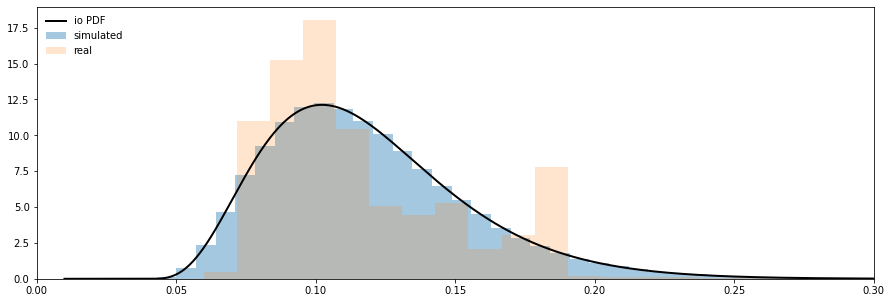

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(0.01, 0.3, 10000)

ax.plot(x, io_gamma.pdf(x), 'k-', lw=2, label='io PDF')

r = io_gamma.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=50, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_xlim(0.0, 0.3)

plt.show()

In [4]:
from scipy.stats import kstest
print(kstest(r, real_data))

KstestResult(statistic=0.19224866765255733, pvalue=0.0)
